In [ ]:
'''
This script uses the EV Charging behaviours dataset (xlsx format)
The script aims to explain what makes people charge at the office at home or publicly
Decision trees, boosted trees, regression and PCA are used
'''

In [16]:
import numpy as np
import datetime as dt
import sklearn
import pandas as pd
from sklearn import preprocessing 

In [17]:
# read data

df = pd.read_excel (r'Data/EV Charging behaviours.xlsx',sheet_name='enlarged data')
X=df.copy()

In [19]:
# encoding of non numerical data


from sklearn.preprocessing import OneHotEncoder
le = preprocessing.LabelEncoder()
#X['medewerker'] = le.fit_transform(X['medewerker'])
X['Kaart ID'] = le.fit_transform(X['Kaart ID'])
X['Platform'] = le.fit_transform(X['Platform'])
X['Number plate'] = le.fit_transform(X['Number plate'].astype(str))
#X['car type'] = le.fit_transform(X['car type'].astype(str))
#X['car type'] = X['car type'].astype(str)
X['Locatie'] = le.fit_transform(X['Locatie'])
X['Land'] = le.fit_transform(X['Land'])
#X['AC or DC'] = le.fit_transform(X['AC or DC'])
#X['Laadpaaltype'] = le.fit_transform(X['Laadpaaltype'])
X['Laadpaal_ID'] = le.fit_transform(X['Laadpaal_ID'].astype(str))
X['Laadpaalexploitant'] = le.fit_transform(X['Laadpaalexploitant'].astype(str))
X['Driver has home charger'] = le.fit_transform(X['Driver has home charger'].astype(str))
X['Within office hours'] = le.fit_transform(X['Within office hours'].astype(str))
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(X[['Main Office','car type','Weekday']]).toarray())
# merge with main df bridge_df on key values
X = X.join(enc_df)
print(X.shape)

(14330, 74)


In [20]:
#clean data

X=X.dropna()

In [48]:
# select target feature to predict


y_paal_type_origin=X['Laadpaaltype']
y_ACDC_origin=X['AC or DC']
y_ACDC = le.fit_transform(y_ACDC_origin.astype(str))
y_paal_type = le.fit_transform(y_paal_type_origin.astype(str))

In [49]:
# Decide what features to take into account in the model


duration = False
percent_charged= False
battery_size=True
percent_laadpaal=False
Geladen_kWh=True
home_charger=True
main_office=True
car_type=True
year=True
weekday=True
within_hours=True
noon=True

In [50]:
# select features


selection=[]
labels=[]

if duration:
    selection.append('Duration in minutes')
if percent_charged:
    selection.append('% of battery charged')
if battery_size:
    selection.append('Battery size')
if percent_laadpaal:
    selection.append('% laadpaal vermogen')
if percent_laadpaal:
    selection.append('Geladen kWh')
if home_charger:
    selection.append('Driver has home charger')
if year:
    selection.append('Year')
if within_hours:
    selection.append('Within office hours')
if noon:
    selection.append('afternoon')
    
    
    
labels=selection.copy()
used_params=selection.copy()
onehot_counter=0


offices=X['Main Office'].unique()
nb_officess=len(offices.tolist())
if main_office:
    classes=[onehot_counter+i for i in range(nb_officess)]
    selection=selection+classes
    labels=labels+offices.tolist()
    used_params.append('Main office')
onehot_counter=onehot_counter+nb_officess

car_types=X['car type'].unique()
nb_car_types=len(car_types.tolist())
if car_type:
    classes=[onehot_counter+i for i in range(nb_car_types)]
    selection=selection+classes
    labels=labels+car_types.tolist()
    used_params.append('car type')
onehot_counter=onehot_counter+nb_car_types

weekdays=X['Weekday'].unique()
nb_weekdays=7
if car_type:
    classes=[onehot_counter+i for i in range(nb_weekdays)]
    selection=selection+classes
    labels=labels+weekdays.tolist()
    used_params.append('Weekday')
onehot_counter=onehot_counter+nb_weekdays

X_selection= X[selection]

In [52]:
# fit tree
# train - validation data split based on individual users
# adjust depth for depth of tree (avoid overfitting)
depth=5



from sklearn import tree
from sklearn.model_selection import train_test_split

users=X["medewerker"]
unique_users=users.unique()

np.random.shuffle(unique_users)
train_users=unique_users[:120]
test_users=unique_users[120:]

X_train_full=X.loc[X['medewerker'].isin(train_users)]
X_test_full=X.loc[X['medewerker'].isin(test_users)]

X_train=X_train_full[selection]
X_test=X_test_full[selection]
y_train=X_train_full['Laadpaaltype']
y_train = le.fit_transform(y_train.astype(str))
y_test=X_test_full['Laadpaaltype']
y_test = le.fit_transform(y_test.astype(str))


clf_paal_type = tree.DecisionTreeClassifier(max_depth=depth,min_samples_leaf=5,criterion='gini')
clf_paal_type = clf_paal_type.fit(X_train, y_train)

In [53]:
#plot tree


from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# create tree object 

# train the model using the full set and check score
print(clf_paal_type.score(X_selection, y_paal_type))


fig=plt.figure(figsize=(100,100),dpi=100)
_=tree.plot_tree(clf_paal_type, filled=True,feature_names=labels,class_names=['office','home','public'])
plt.title("Decision tree")
fig.savefig("xPaaltype decistion_tree(depth="+str(depth)+")"+str(used_params)+".png")

plt.show()

0.7495318702718897


In [39]:
# evaluate classifier (tree)


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print('train score:' + str(clf_paal_type.score(X_train, y_train)))
print('test score:' + str(clf_paal_type.score(X_test, y_test)))

train score:0.8037230568256042
test score:0.7116446578631452


In [40]:
# boosted tree

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score


boosted_clf=GradientBoostingClassifier(n_estimators=1000)
boosted_clf=boosted_clf.fit(X_train, y_train)

print('train score boosted:' + str(boosted_clf.score(X_train, y_train)))
print('test score boosted:' + str(boosted_clf.score(X_test, y_test)))

y_boosted=boosted_clf.predict(X_test)

print(y_boosted)

y_pred_boosted=boosted_clf.predict(X_test)
precision_score(y_test, y_pred_boosted,average="weighted")

train score boosted:0.8762246897452646
test score boosted:0.7392557022809124
[0 0 0 ... 1 1 2]


0.7494509548302609

In [41]:
# scale features for PCA

scaler = preprocessing.StandardScaler().fit(X_selection)
X_scaled = scaler.transform(X_selection)

(13351, 42)
[0.06985683 0.04974547 0.04625302]
[-0.50187302 -0.2362178  -0.3662443   0.1747625  -0.00979382 -0.08760477
 -0.13571032 -0.01831209  0.11957908  0.24299815 -0.03242987  0.00742821
 -0.0862467  -0.          0.03764893 -0.09154754  0.32225402  0.0612792
  0.03560478 -0.02468885 -0.02765631  0.02205212 -0.1107784   0.00512678
 -0.01833492  0.11219835 -0.31257783  0.04635417 -0.11399331 -0.09095759
  0.32353173  0.0025509  -0.01790659 -0.01580815 -0.04118764 -0.0497255
 -0.00838525  0.03955561 -0.11345981 -0.12529577  0.09017392  0.06783044]
['Kortrijk', 'Volkswagen ID.4 1st', 'Hyundai Ioniq', 'Zwijndrecht', 'Wednesday', 'afternoon', 'Skoda Enyaq 80', 'Volkswagen ID.3 Pro S', 'Hasselt', 'Volkswagen ID.3 1st', 'Tesla Model 3 Performance', 'KIA E-NIRO 64', 'Tesla Model 3 Long range', 'Zelzate', 'Smart Forfour', 'Louvain-La-Neuve', 'Thursday', 'Skoda Enyaq 60', 'KIA E-NIRO 39', 'Tuesday', 'Volkswagen ID.3 Pro', 'Friday', 'Lummen', 'Berchem', 'Monday', 'Peugeot E-2008', 'BMW i3', 

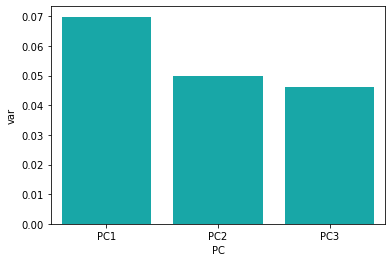

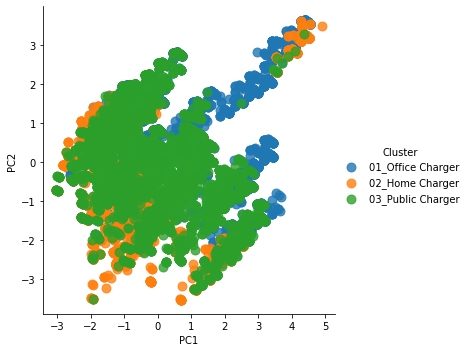

In [47]:
# PCA
# prints the values of one of the principal components
comp_to_print=0

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
# load make_blobs to simulate data
from sklearn.datasets import make_blobs
# load decomposition to do PCA analysis with sklearn
from sklearn import decomposition

X1=X_scaled
Y1=y_paal_type_origin

print(X1.shape)
pca = decomposition.PCA(n_components=3)
pc = pca.fit_transform(X1)
pc_df = pd.DataFrame(data = pc , 
        columns = ['PC1','PC2','PC3'])
pc_df['Cluster'] = Y1.tolist()
print(pca.explained_variance_ratio_)
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3']})
sns.barplot(x='PC',y="var", 
           data=df, color="c");
sns.lmplot( x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80},# specify the point size
  x_ci='sd'      
          ) 
comps=pca.components_[comp_to_print]
print(comps)
abs_comp =  np.array([abs(el) for el in comps])


# sort for most important features
inds=abs_comp.argsort()
vals=[comps[i] for i in inds]
features=[selection[i] for i in inds]
# get names of features back for non numerical data
for i in range(len(features)):
    featr=features[i]
    if isinstance(featr, int):
        if featr<=9:
            features[i]=offices[featr]
        elif featr<=29:
            features[i]=car_types[featr-10]
        else:
            features[i]=weekdays[featr-30]
        
    
print(features)

